Implement a convolutional autoencoder to compress and reconstruct images.
Train on CIFAR-10.
Measure compression ratio and reconstruction quality.

100%|██████████| 170M/170M [00:01<00:00, 91.9MB/s]


Epoch [1/20], Loss: 0.0130
Epoch [2/20], Loss: 0.0082
Epoch [3/20], Loss: 0.0070
Epoch [4/20], Loss: 0.0055
Epoch [5/20], Loss: 0.0048
Epoch [6/20], Loss: 0.0041
Epoch [7/20], Loss: 0.0040
Epoch [8/20], Loss: 0.0042
Epoch [9/20], Loss: 0.0040
Epoch [10/20], Loss: 0.0034
Epoch [11/20], Loss: 0.0035
Epoch [12/20], Loss: 0.0032
Epoch [13/20], Loss: 0.0041
Epoch [14/20], Loss: 0.0029
Epoch [15/20], Loss: 0.0026
Epoch [16/20], Loss: 0.0025
Epoch [17/20], Loss: 0.0028
Epoch [18/20], Loss: 0.0026
Epoch [19/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0024


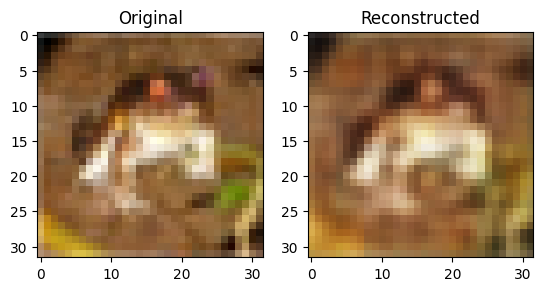

Compression Ratio: 3.0


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([transforms.ToTensor()])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


num_epochs = 20
for epoch in range(num_epochs):
    for data in trainloader:
        imgs, _ = data
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


def show_images(orig, recon):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(np.transpose(orig.cpu().numpy(), (1, 2, 0)))
    axs[0].set_title("Original")
    axs[1].imshow(np.transpose(recon.cpu().detach().numpy(), (1, 2, 0)))
    axs[1].set_title("Reconstructed")
    plt.show()


test_img, _ = trainset[0]
test_tensor = test_img.unsqueeze(0).to(device)
with torch.no_grad():
    recon = model(test_tensor)

show_images(test_img, recon[0])


def calc_compression_ratio():
    orig = 3 * 32 * 32
    encoded = 64 * 4 * 4
    return orig / encoded

print("Compression Ratio:", calc_compression_ratio())
